# ARIMA Model Training and Analysis

This notebook demonstrates the process of training and evaluating an ARIMA model on S&P 500 log returns, including stationarity tests, autocorrelation analysis, and profit visualization for different ARIMA hyperparameters.

### 1. Set Working Directory

Ensure the working directory is set to the main project folder.

In [1]:
import os
import sys

# Change working directory to the parent (main) directory
current_dir = os.getcwd() 
print(f"Current Working Directory: {current_dir}")
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
os.chdir(parent_dir)
current_dir = os.getcwd()
print(f"Current Working Directory: {current_dir}")
# We need to be in the main directory that contains tests, models, etc folders

Current Working Directory: /mnt/c/Users/ASUS/OneDrive - SISSA/study/research/neural theory/data_science_finance/deepQN_trading/test_notebooks
Current Working Directory: /mnt/c/Users/ASUS/OneDrive - SISSA/study/research/neural theory/data_science_finance/deepQN_trading


### 2. Import Required Libraries and Modules

In [9]:
from ARIMA_model import log_return_df, threshold_array, window_array, arima_profit
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pickle
from trading_env_class import stock

### 3. Load Training Parameters and Best ARIMA Hyperparameters

In [3]:
with open('dqn_trading_results.pkl', 'rb') as f:
    results = pickle.load(f)
    train_dates = results['train_dates']
    threshold = results['ARIMA_best_threshold']
    window_size = results['ARIMA_best_window_size']

Ntrain = len(train_dates)

### 4. Visualize Log of Daily Returns

        Date  Log_Daily_Return
1 2010-01-05          0.003111
2 2010-01-06          0.000545
3 2010-01-07          0.003993
4 2010-01-08          0.002878
5 2010-01-11          0.001745


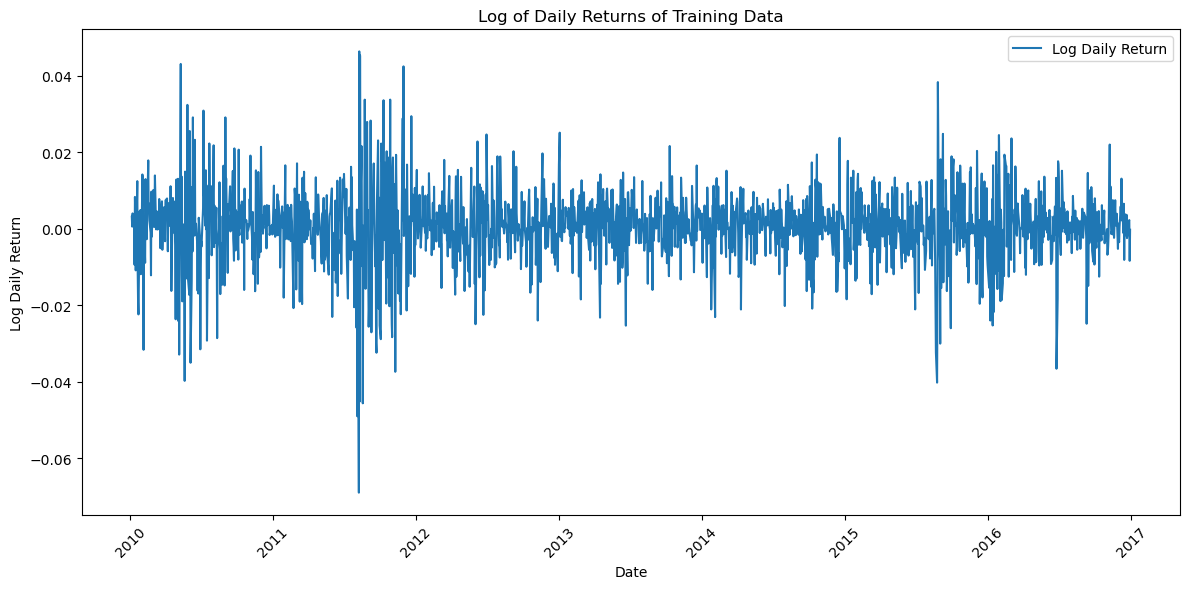

In [4]:
print(log_return_df.head())
# Plot the log of daily returns
plt.figure(figsize=(12, 6))
plt.plot(log_return_df['Date'][:Ntrain], log_return_df['Log_Daily_Return'][:Ntrain], label='Log Daily Return')
plt.title('Log of Daily Returns of Training Data')
plt.xlabel('Date')
plt.ylabel('Log Daily Return')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

### 5. Test for Stationarity

Time series are stationary if they do not contain trends or seasonal swings. The Dickey-Fuller test can be used to test for stationarity.

In [5]:
# Perform Dickey-Fuller test
dftest = adfuller(log_return_df.Log_Daily_Return[:Ntrain], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value ({0})'.format(key)] = value
    
dfoutput

Test Statistic                -9.553383e+00
p-value                        2.536530e-16
#Lags Used                     2.500000e+01
Number of Observations Used    1.734000e+03
Critical Value (1%)           -3.434127e+00
Critical Value (5%)           -2.863208e+00
Critical Value (10%)          -2.567658e+00
dtype: float64

### 6. ACF and PACF Charts

Autocorrelation and partial autocorrelation charts help us choose hyperparameters for the ARIMA model.

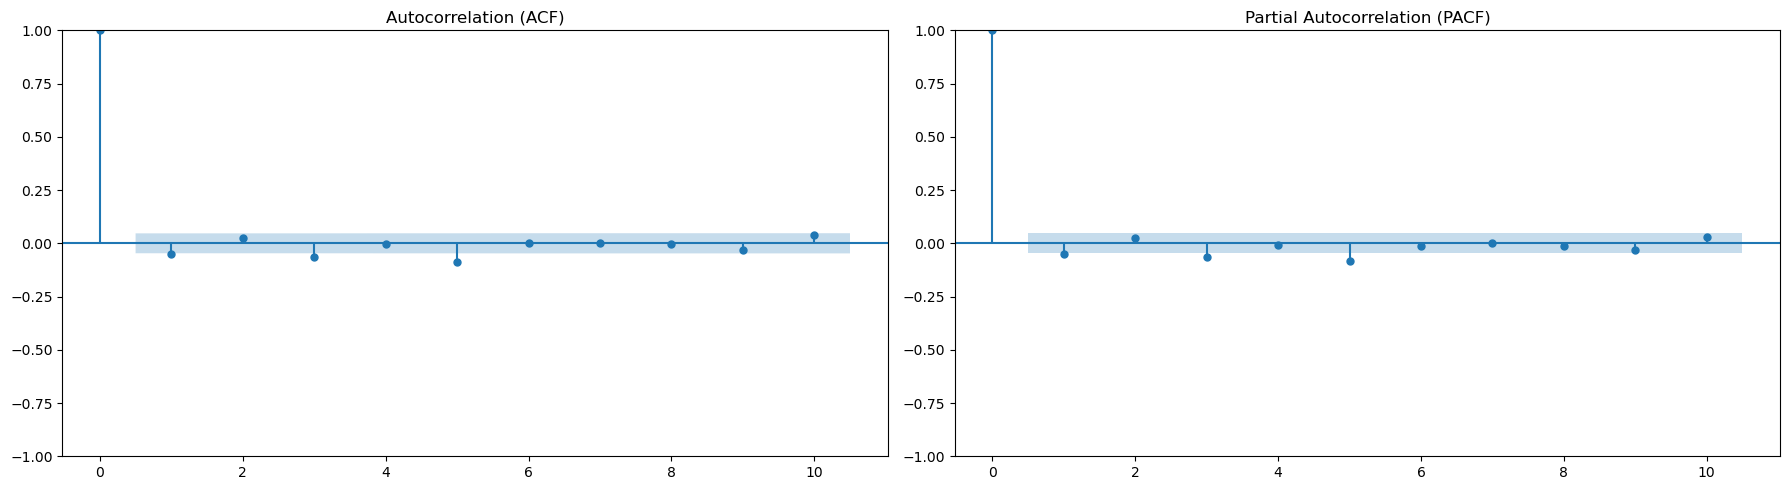

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

plot_acf(log_return_df['Log_Daily_Return'][:Ntrain], lags=10, ax=axes[0])
axes[0].set_title('Autocorrelation (ACF)')

plot_pacf(log_return_df['Log_Daily_Return'][:Ntrain], lags=10, ax=axes[1])
axes[1].set_title('Partial Autocorrelation (PACF)')

plt.tight_layout()
plt.show()

### 7. Fit ARIMA on the Whole Training Dataset

In [7]:
from statsmodels.tsa.arima.model import ARIMA

# Notice that you have to use udiff - the differenced data rather than the original data.
ar1 = ARIMA(log_return_df['Log_Daily_Return'][:Ntrain], order = (1, 0,1)).fit()
ar1.summary()

/home/pranjal238/miniconda3/envs/conv_emerge/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/pranjal238/miniconda3/envs/conv_emerge/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/pranjal238/miniconda3/envs/conv_emerge/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       Log_Daily_Return   No. Observations:                 1760
Model:                 ARIMA(1, 0, 1)   Log Likelihood                5643.198
Date:                Wed, 24 Sep 2025   AIC                         -11278.397
Time:                        15:15:02   BIC                         -11256.504
Sample:                             0   HQIC                        -11270.306
                               - 1760                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      1.662      0.097   -6.91e-05       0.001
ar.L1         -0.9649      0.014    -67.519      0.000      -0.993      -0.937
ma.L1          0.9185      0.018     51.001      0.000       0.883       0.954
sigma2      9.604e-05   2.02e-06     47.502      0.000    9.21e-05       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              1028.63
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.53   Skew:                            -0.42
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 8. Visualize Profit Curves for Different Thresholds and Window Sizes

In [ ]:
# Calculate profit for different threshold values using the best window_size
profits = []
for th in threshold_array:
    SP = stock('^GSPC')
    profit = arima_profit(SP, 0, Ntrain, window_size, th, 1, 1)
    profits.append(profit)

# Calculate profit for different window sizes using the best threshold
profits_window = []
for win in window_array:
    SP = stock('^GSPC')
    profit = arima_profit(SP, 0, Ntrain, win, threshold, 1, 1)
    profits_window.append(profit)

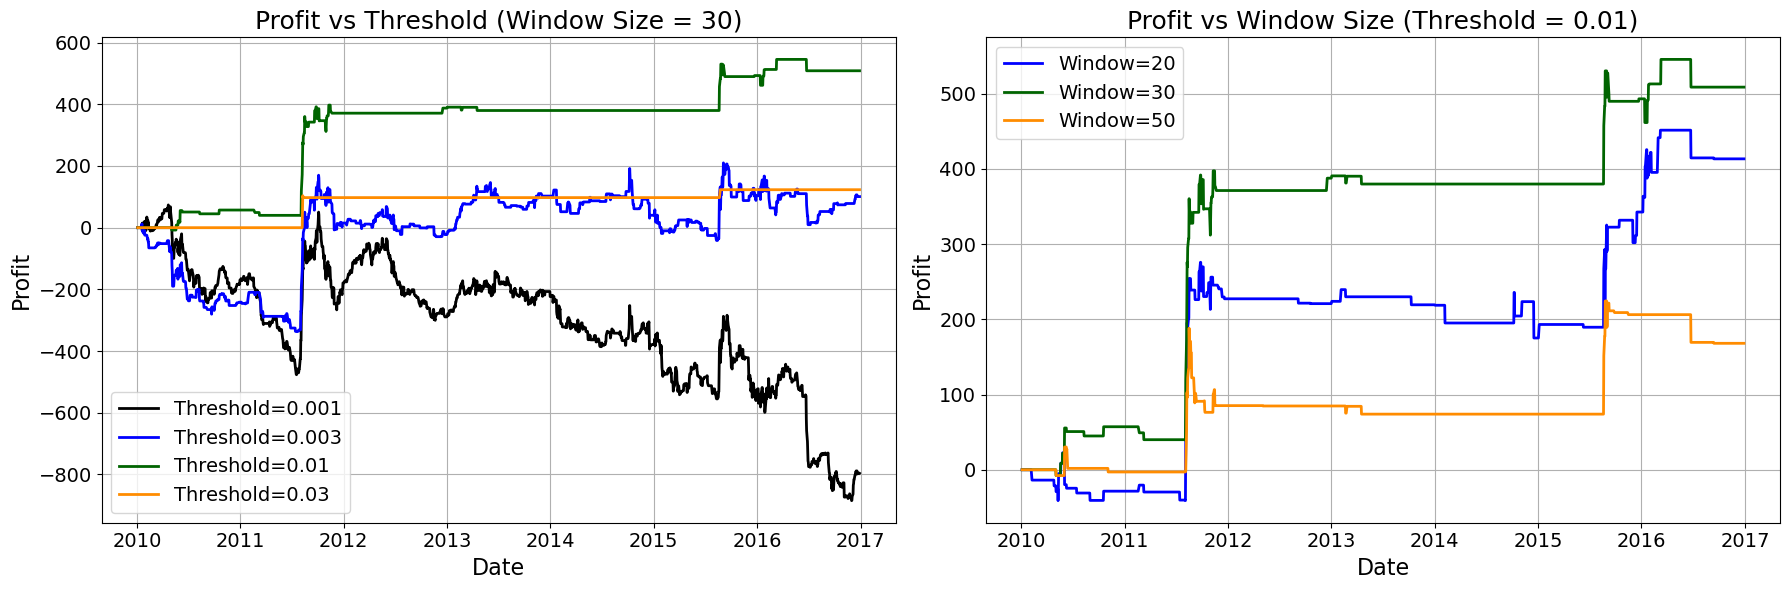

In [17]:
# Plot profit curves for different ARIMA hyperparameters
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

colors = ['black', 'blue', 'darkgreen', 'darkorange']

# Plot for different thresholds
for i, profit in enumerate(profits):
    axes[0].plot(train_dates, profit[:-1], label=f'Threshold={threshold_array[i]}', color=colors[i], linewidth=2)
axes[0].legend(fontsize=14)
axes[0].set_xlabel('Date', fontsize=16)
axes[0].set_ylabel('Profit', fontsize=16)
axes[0].set_title(f'Profit vs Threshold (Window Size = {window_size})', fontsize=18)
axes[0].grid(True)
axes[0].tick_params(axis='both', labelsize=14)

# Plot for different window sizes (skip the first, as in your original code)
for i, profit in enumerate(profits_window[1:]):
    axes[1].plot(train_dates, profit[:-1], label=f'Window={window_array[i+1]}', color=colors[i+1], linewidth=2)
axes[1].legend(fontsize=14)
axes[1].set_xlabel('Date', fontsize=16)
axes[1].set_ylabel('Profit', fontsize=16)
axes[1].set_title(f'Profit vs Window Size (Threshold = {threshold})', fontsize=18)
axes[1].grid(True)
axes[1].tick_params(axis='both', labelsize=14)

plt.tight_layout()
plt.show()